In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math as m
import os

from scipy.stats import gaussian_kde

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling3D, GlobalMaxPooling2D, GlobalMaxPooling3D, Reshape, Dense, Flatten, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda

In [2]:
ROOT_DIR = os.getcwd()
ROOT_DIR

'C:\\Users\\HK Joshi\\Documents\\Github\\major_project\\biocube'

## Generate template using Infinity cube

### Infinity  cube code for RGB image

In [18]:
def infinte_cube(img):
    ''' Perform atomic operations on image similar to infinity cube. On performing these steps 'n' times, we can generate the biometric template.
        Input:
            img: The input image
        Output:
            returns the image after performing atomic operation once
    '''
    # Make width dimension even, if it is not
    if img.shape[1]%2 != 0:
        img = img[:, 0:img.shape[1]-1, :]    

    # Expand horizontally
    new_img = cv2.resize(img, (2*img.shape[1], img.shape[0]))

    # Make the height and width of even number
    if new_img.shape[0]%2 != 0:
        new_img = new_img[0:-2, :, :]
    if new_img.shape[1]%2 != 0:
        new_img = new_img[:, 0:-2, :]
#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image vertically into top image and bottom image
    height, width, channels = new_img.shape
    half_height = height//2

    top_img, bottom_img = new_img[:half_height, :], new_img[half_height:, :]

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
#     top_img.shape, bottom_img.shape

    # Perform XOR operation between top and bottom section of images
    XOR_img = np.bitwise_xor(top_img, bottom_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width, channels = XOR_img.shape
    quarter_width = width//4
    if width%4 != 0:
        quarter_width = int(width//4)
        XOR_img = XOR_img[:, 1:XOR_img.shape[1]-1, :]

    img1, img2, img3, img4 = XOR_img[:, 0:quarter_width], XOR_img[:, quarter_width: 2*quarter_width], XOR_img[:, 2*quarter_width:3*quarter_width], XOR_img[:, 3*quarter_width:]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new top and bottom images by merging middle two images and two outermost images respectively 
    top_img = cv2.hconcat([img2, img3])
    bottom_img = cv2.hconcat([img1, img4])

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
    
    # Form the image of originaly shape by concatenating the two images vertically
#     print(top_img.shape)
#     print(bottom_img.shape)
    new_img = cv2.vconcat([top_img, bottom_img])

#     plt.imshow(new_img)
#     new_img.shape
    
    # Expand vertically
    new_img = cv2.resize(new_img, (new_img.shape[1], 2*new_img.shape[0]))

#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image horizontally into left image and right image
    height, width, channels = new_img.shape
    half_width = width//2

    left_img, right_img = new_img[:, :half_width], new_img[:, half_width:]

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()
#     left_img.shape, right_img.shape

    # Perform XOR operation between left and right section of images
    XOR_img = np.bitwise_xor(left_img, right_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width, channels = XOR_img.shape
    quarter_height = height//4

    img1, img2, img3, img4 = XOR_img[0:quarter_height, :], XOR_img[quarter_height:2*quarter_height, :], XOR_img[2*quarter_height:3*quarter_height, :], XOR_img[3*quarter_height:, :]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new left and right images by merging middle two images and two outermost images respectively 
    left_img = cv2.vconcat([img2, img3])
    right_img = cv2.vconcat([img1, img4])

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()

    # Form the image of originaly shape by concatenating the two images vertically
    new_img = cv2.hconcat([left_img, right_img])
#     plt.imshow(new_img)
#     new_img.shape

    return new_img

# Generate template for a given image
def inf_cube_with_itr(icwi_img, iterations):
    ''' Create a template for the given image with specified number of iterations
        Input:
            icwi_img: an image for which we want to generate the template
            iterations: the nuber of times we want to perform infinty cube transforamtions to generate the tempalte
        Output:
            returns the generated template for the given input image
    '''
    icwi_template = icwi_img.copy()
    for _ in range(iterations):
        icwi_template = infinte_cube(icwi_template)
    return icwi_template


# Generate tempalte for whole batch at once
def gen_batch_template(gbt_imgs):
    ''' Generate a set of templates for the given set of images
        Input:
            gbt_imgs: a list of input images
        Output:
            returns the generated template for every image present in the input set
    '''
    gbt_temp = []
    for gbt_img_temp in gbt_imgs:
        gbt_img_temp = np.array(gbt_img_temp, dtype= 'uint8')
        gbt_img_temp = inf_cube_with_itr(gbt_img_temp, iterations)
        gbt_temp.append(gbt_img_temp)
    return gbt_temp

### Infinity  cube code for grayscale image

In [4]:
def infinte_cube_for_gray_img(img):
    ''' Perform atomic operations on image similar to infinity cube. On performing these steps 'n' times, we can generate the biometric template.
        Input:
            img: The input image
        Output:
            returns the image after performing atomic operation once
    '''
    # Make width dimension even, if it is not
    if img.shape[1]%2 != 0:
        img = img[:, 0:img.shape[1]-1, :]    

    # Expand horizontally
    new_img = cv2.resize(img, (2*img.shape[1], img.shape[0]))

    # Make the height and width of even number
    if new_img.shape[0]%2 != 0:
        new_img = new_img[0:-2, :, :]
    if new_img.shape[1]%2 != 0:
        new_img = new_img[:, 0:-2, :]
#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image vertically into top image and bottom image
    height, width = new_img.shape
    half_height = height//2

    top_img, bottom_img = new_img[:half_height, :], new_img[half_height:, :]

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
#     top_img.shape, bottom_img.shape

    # Perform XOR operation between top and bottom section of images
    XOR_img = np.bitwise_xor(top_img, bottom_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width = XOR_img.shape
    quarter_width = width//4
    if width%4 != 0:
        quarter_width = int(width//4)
        XOR_img = XOR_img[:, 1:XOR_img.shape[1]-1, :]

    img1, img2, img3, img4 = XOR_img[:, 0:quarter_width], XOR_img[:, quarter_width: 2*quarter_width], XOR_img[:, 2*quarter_width:3*quarter_width], XOR_img[:, 3*quarter_width:]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new top and bottom images by merging middle two images and two outermost images respectively 
    top_img = cv2.hconcat([img2, img3])
    bottom_img = cv2.hconcat([img1, img4])

#     plt.imshow(top_img)
#     plt.show()
#     plt.imshow(bottom_img)
#     plt.show()
    
    # Form the image of originaly shape by concatenating the two images vertically
#     print(top_img.shape)
#     print(bottom_img.shape)
    new_img = cv2.vconcat([top_img, bottom_img])

#     plt.imshow(new_img)
#     new_img.shape
    
    # Expand vertically
    new_img = cv2.resize(new_img, (new_img.shape[1], 2*new_img.shape[0]))

#     plt.imshow(new_img)
#     plt.show()
#     new_img.shape

    # Split image horizontally into left image and right image
    height, width = new_img.shape
    half_width = width//2

    left_img, right_img = new_img[:, :half_width], new_img[:, half_width:]

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()
#     left_img.shape, right_img.shape

    # Perform XOR operation between left and right section of images
    XOR_img = np.bitwise_xor(left_img, right_img)

#     plt.imshow(XOR_img)

    # Split image into 4 equal parts
    height, width = XOR_img.shape
    quarter_height = height//4

    img1, img2, img3, img4 = XOR_img[0:quarter_height, :], XOR_img[quarter_height:2*quarter_height, :], XOR_img[2*quarter_height:3*quarter_height, :], XOR_img[3*quarter_height:, :]

#     plt.imshow(img1)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()

    # Create new left and right images by merging middle two images and two outermost images respectively 
    left_img = cv2.vconcat([img2, img3])
    right_img = cv2.vconcat([img1, img4])

#     plt.imshow(left_img)
#     plt.show()
#     plt.imshow(right_img)
#     plt.show()

    # Form the image of originaly shape by concatenating the two images vertically
    new_img = cv2.hconcat([left_img, right_img])
#     plt.imshow(new_img)
#     new_img.shape

    return new_img

# Generate template for a given image
def inf_cube_with_itr_for_gray_img(icwi_img, iterations):
    ''' Create a template for the given image with specified number of iterations
        Input:
            icwi_img: an image for which we want to generate the template
            iterations: the nuber of times we want to perform infinty cube transforamtions to generate the tempalte
        Output:
            returns the generated template for the given input image
    '''
    icwi_template = icwi_img.copy()
    for _ in range(iterations):
        icwi_template = infinte_cube_for_gray_img(icwi_template)
    return icwi_template


# Generate tempalte for whole batch at once
def gen_batch_template_for_gray_img(gbt_imgs):
    ''' Generate a set of templates for the given set of images
        Input:
            gbt_imgs: a list of input images
        Output:
            returns the generated template for every image present in the input set
    '''
    gbt_temp = []
    for gbt_img_temp in gbt_imgs:
        gbt_img_temp = np.array(gbt_img_temp, dtype= 'uint8')
        gbt_img_temp = inf_cube_with_itr_for_gray_img(gbt_img_temp, iterations)
        gbt_temp.append(gbt_img_temp)
    return gbt_temp

### Infinity  cube code Exchange pixels

In [7]:
def infinte_cube_with_exchange(img, save_img = False):
    
    img = cv2.resize(img, (2*img.shape[1], int(0.5*img.shape[0])), cv2.INTER_LANCZOS4)
    if save_img == True:
        plt.imshow(img)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig('1.png', bbox_inches='tight')
        plt.show()

    height, width, _ = img.shape
    half_height = height//2
    
    top_img, bottom_img = img[:half_height, :], img[half_height:, :]

    if save_img == True:
        plt.imshow(top_img)
        plt.axis('off')
        plt.savefig('2.1.png', bbox_inches='tight')
        plt.imshow(bottom_img)
        plt.axis('off')
        plt.savefig('2.2.png', bbox_inches='tight')

    exch_img = cv2.vconcat([bottom_img, top_img])
    
    if save_img == True:
        plt.imshow(exch_img)
        plt.axis('off')
        plt.savefig('2.3.png', bbox_inches='tight')

    
    height, width, _ = exch_img.shape
    quarter_width = width//4
    if width%4 != 0:
        quarter_width = int(width//4)
        exch_img = exch_img[:, 1:exch_img.shape[1]-1, :]

    img1, img2, img3, img4 = exch_img[:, 0:quarter_width], exch_img[:, quarter_width: 2*quarter_width], exch_img[:, 2*quarter_width:3*quarter_width], exch_img[:, 3*quarter_width:]

    if save_img == True:
        plt.imshow(img1)
        plt.axis('off')
        plt.savefig('3.1.png', bbox_inches='tight')

        plt.imshow(img2)
        plt.axis('off')
        plt.savefig('3.2.png', bbox_inches='tight')

        plt.imshow(img3)
        plt.axis('off')
        plt.savefig('3.3.png', bbox_inches='tight')


        plt.imshow(img4)
        plt.axis('off')
        plt.savefig('3.4.png', bbox_inches='tight')


    # Create new top and bottom images by merging middle two images and two outermost images respectively 
    top_img = cv2.hconcat([img2, img3])
    bottom_img = cv2.hconcat([img1, img4])
    
    if save_img == True:
        plt.imshow(top_img)
        plt.axis('off')
        plt.savefig('3.5.png', bbox_inches='tight')

        plt.imshow(bottom_img)
        plt.axis('off')
        plt.savefig('3.6.png', bbox_inches='tight')

    # Form the image of originaly shape by concatenating the two images vertically
    new_img = cv2.vconcat([top_img, bottom_img])

    if save_img == True:
        plt.imshow(new_img)
        plt.axis('off')
        plt.savefig('3.7.png', bbox_inches='tight')

    # print('do vertically')
    new_img = cv2.resize(new_img, (int(0.5*new_img.shape[1]), (2*new_img.shape[0])), cv2.INTER_LANCZOS4)
    
    if save_img == True:
        plt.imshow(new_img)
        plt.axis('off')
        plt.savefig('4.1.png', bbox_inches='tight')

    
    height, width, _ = new_img.shape
    half_width = width//2

    left_img, right_img = new_img[:, :half_width], new_img[:, half_width:]
    
    if save_img == True:
        plt.imshow(left_img)
        plt.axis('off')
        plt.savefig('5.1.png', bbox_inches='tight')

        plt.imshow(right_img)
        plt.axis('off')
        plt.savefig('5.2.png', bbox_inches='tight')

    # Exchange top and bottom pixel values
    exch_img = cv2.hconcat([left_img, right_img])

    if save_img == True:
        plt.imshow(exch_img)
        plt.axis('off')
        plt.savefig('5.3.png', bbox_inches='tight')

    # Split image into 4 equal parts
    #     height, width, channels = exch_img.shape
    height, width, _ = exch_img.shape
    quarter_height = height//4

    img1, img2, img3, img4 = exch_img[0:quarter_height, :], exch_img[quarter_height:2*quarter_height, :], exch_img[2*quarter_height:3*quarter_height, :], exch_img[3*quarter_height:, :]

    if save_img == True:
        plt.imshow(img1)
        plt.axis('off')
        plt.savefig('6.1.png', bbox_inches='tight')

        plt.imshow(img2)
        plt.axis('off')
        plt.savefig('6.2.png', bbox_inches='tight')

        plt.imshow(img3)
        plt.axis('off')
        plt.savefig('6.3.png', bbox_inches='tight')

        plt.imshow(img4)
        plt.axis('off')
        plt.savefig('6.4.png', bbox_inches='tight')

    # Create new left and right images by merging middle two images and two outermost images respectively 
    left_img = cv2.vconcat([img2, img3])
    right_img = cv2.vconcat([img1, img4])

    if save_img == True:
        plt.imshow(left_img)
        plt.axis('off')
        plt.savefig('6.5.png', bbox_inches='tight')

        plt.imshow(right_img)
        plt.axis('off')
        plt.savefig('6.6.png', bbox_inches='tight')

    # Form the image of originaly shape by concatenating the two images vertically
    new_img = cv2.hconcat([left_img, right_img])
    
    if save_img == True:
        plt.imshow(new_img)
        plt.axis('off')
        plt.savefig('6.7.png', bbox_inches='tight')

    return new_img

# Generate template for a given image
def inf_cube_with_itr_with_exchange(icwi_img, iterations):
    ''' Create a template for the given image with specified number of iterations
        Input:
            icwi_img: an image for which we want to generate the template
            iterations: the nuber of times we want to perform infinty cube transforamtions to generate the tempalte
        Output:
            returns the generated template for the given input image
    '''
    icwi_template = icwi_img.copy()
    for _ in range(iterations):
        icwi_template = infinte_cube_with_exchange(icwi_template)
    return icwi_template


# Generate tempalte for whole batch at once
def gen_batch_template_with_exchange(gbt_imgs):
    ''' Generate a set of templates for the given set of images
        Input:
            gbt_imgs: a list of input images
        Output:
            returns the generated template for every image present in the input set
    '''
    gbt_temp = []
    for gbt_img_temp in gbt_imgs:
        gbt_img_temp = np.array(gbt_img_temp, dtype= 'uint8')
        gbt_img_temp = inf_cube_with_itr_with_exchange(gbt_img_temp, iterations)
        gbt_temp.append(gbt_img_temp)
    return gbt_temp

In [27]:
img_path = r'datasets\jabcode\user_1\1.png'
# save_path = r'datasets\jabcode_exchange_replace'
save_path = r'datasets\jabcode_exchange_XOR'

for user_class in range(1, 221):
    class_name = f'user_{user_class}'
    
    img_path = f'datasets\\jabcode\\user_{user_class}\\1.png'
    img = cv2.imread(img_path)
#     new_img = infinte_cube_with_exchange(img)
    new_img = infinte_cube(img)
    
    class_dir = os.path.join(os.getcwd(), save_path, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    
    new_img_path = os.path.join(class_dir, '1.png')
    plt.imsave(new_img_path, new_img)
# img = cv2.imread(img_path)

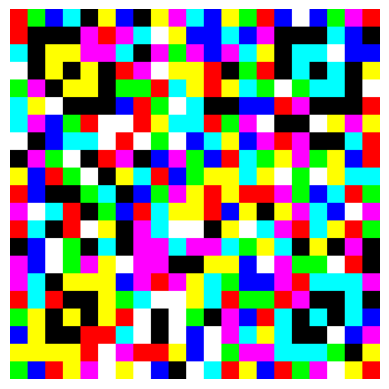

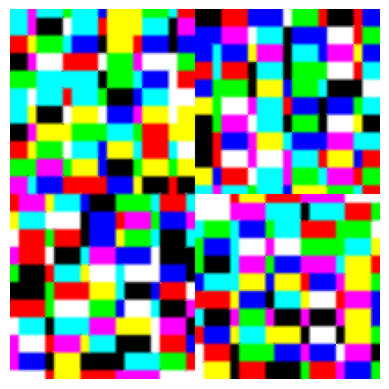

In [26]:
img_path = r'datasets\jabcode\user_1\1.png'
img = cv2.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# new_img = infinte_cube_with_exchange(img)
new_img = infinte_cube(img)
plt.imshow(new_img)
plt.axis('off')
plt.show()

## Load images from directory

In [6]:
# Read all the dataset from directory
dataset_folder = 'datasets/LR-VERA-fingervein'
data_directory = os.path.join(ROOT_DIR, dataset_folder)

In [7]:
images = image_dataset_from_directory(
    data_directory,
    seed=42,
    batch_size=64, # Every dataset has 6 images
    image_size=(250,665),
    label_mode='int',
    shuffle=False
)

Found 1320 files belonging to 220 classes.


## Pre-processing

### Equalized Images

In [8]:
def get_equalized_image(img):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # plt.imshow(img, cmap='gray')
    # plt.axis('off')

    # Removes fingerprint data
    kernel_l, kernel_w = img.shape[0], img.shape[1]
    if kernel_l % 2 == 0:
        kernel_l -= 1
    if kernel_w % 2 == 0:
        kernel_w -= 1
    
    gaussian_img1 = cv2.GaussianBlur(img.copy(), (kernel_l, 1), 1)
    gaussian_img2 = cv2.GaussianBlur(img.copy(), (1, kernel_w), 1)

    # plt.imshow(gaussian_img1, cmap='gray')
    # plt.show()

    # plt.imshow(gaussian_img2, cmap='gray')
    # plt.show()

    diff1 = np.abs(img - gaussian_img1)
    diff2 = np.abs(img - gaussian_img2)

    # plt.imshow(diff1, cmap='gray')
    # plt.show()
    # plt.imshow(diff2, cmap='gray')
    # plt.show()

    new_gauss_img = np.abs( img - (2*diff1 + diff2) )
    # plt.imshow(new_gauss_img, cmap='gray')

    # Adjust gamma
    gamma_adjust_img = np.array(255*(new_gauss_img.copy()/255)**0.2, dtype='uint8')
    # plt.imshow(gamma_adjust_img, cmap='gray')
    
    # plt.figure(figsize=(17,4))
    # plt.subplot(121)
    # val = plt.hist(img.ravel(), bins=256, range=(0, 255), fc='k', ec='k') 
    # plt.title('Image histogram')

    # plt.subplot(122)
    # val = plt.hist(gamma_adjust_img.ravel(), bins=256, range=(0, 255), fc='k', ec='k') 
    # plt.title('Preprocessed Image histogram')
    
    equalized_img = cv2.equalizeHist(gamma_adjust_img)
    
    # plt.figure(figsize=(17,4))
    # plt.subplot(121)
    # val = plt.imshow(gamma_adjust_img, cmap='gray')

    # plt.subplot(122)
    # val = plt.imshow(equalized_img, cmap='gray')
    
    # val = plt.hist(equalized_img.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
    # plt.title('Equalized Preprocessed Image histogram')
    return equalized_img

In [9]:
equalized_imgs = []
img_labels = []
for imgs, labels in images.take(-1):    
    equalized_img = []
    for img, label in zip(imgs, labels):
        
        eql_img = get_equalized_image(img)

        equalized_imgs.append(eql_img)
        img_labels.append(label)

equalized_imgs = np.array(equalized_imgs)
img_labels = np.array(img_labels)

In [10]:
equalized_imgs.shape, img_labels.shape

((1320, 250, 665), (1320,))

(-0.5, 664.5, 249.5, -0.5)

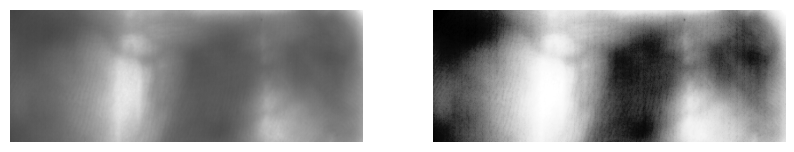

In [11]:
plt.figure(figsize=(10,2))
plt.subplot(121)
for imgs, lbl in images.take(-1):
    plt.imshow(np.uint8(imgs[0]))
    plt.axis('off')
    break

plt.subplot(122)
plt.imshow(equalized_imgs[0], cmap='gray')
plt.axis('off')

### CLAHE

In [10]:
clahe_imgs = []
img_labels = []
for imgs, labels in images.take(-1):    
    clahe_img = []
    for img, label in zip(imgs, labels):
        gb_img = np.array(img, dtype='uint8')

        gb_img = cv2.GaussianBlur(gb_img, (3,3), sigmaX=2)
        clahe = cv2.createCLAHE(clipLimit =8.0, tileGridSize=(9,9))

        R, G, B = cv2.split(gb_img)
        CLAHEoutput_R = clahe.apply(R)
        CLAHEoutput_G = clahe.apply(G)
        CLAHEoutput_B = clahe.apply(B)

        cl_img = cv2.merge((CLAHEoutput_R, CLAHEoutput_G, CLAHEoutput_B))

        # clahe_img.append(cl_img)
        clahe_imgs.append(cl_img)
        img_labels.append(label)
    # clahe_imgs.append(np.array(clahe_img))
clahe_imgs = np.array(clahe_imgs)
img_labels = np.array(img_labels)

In [11]:
clahe_imgs.shape, img_labels.shape

((1320, 250, 665, 3), (1320,))

## Feature Extraction using CBAM (Convolutional Block Attention Module)

In [12]:
def lightweight_CN(input_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size, name='Lightweight-Input-Layer'),
        tf.keras.layers.Conv2D(16, (5,5), name='Conv2D-1'),
        tf.keras.layers.BatchNormalization(name='BN-1'),
        tf.keras.layers.ReLU(name='ReLU-1'),
        tf.keras.layers.MaxPooling2D((3,3), name='MaxPooling-1'),

        tf.keras.layers.Conv2D(32, (5,5), name='Conv2D-2'),
        tf.keras.layers.BatchNormalization(name='BN-2'),
        tf.keras.layers.ReLU(name='ReLU-2'),
        tf.keras.layers.MaxPooling2D((3,3), name='MaxPooling-2')])
    
    return model

def channel_attention(input_feature, ratio=8):
    
    channel = input_feature.shape[-1]
    
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros', name='Shared-Layer-One')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros', name='Shared-Layer-Two')


    avg_pool = GlobalAveragePooling2D(name='CAM-GlobalAveragePooling')(input_feature)
    avg_pool = Reshape((1, 1, 1, channel), name='CAM-Reshape-AvgPool')(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D(name='CAM-GlobalMaxPooling')(input_feature)
    max_pool = Reshape((1, 1, 1, channel), name='CAM-Reshape-MaxPool')(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    feature = Add(name='CAM-Add')([avg_pool, max_pool])
    feature = Activation('sigmoid', name='CAM-Sigmoid-Layer')(feature)

    return tf.keras.layers.multiply([input_feature, feature], name='CAM-Multiply')


def spatial_attention(input_feature, kernel_size=7):
    
    avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True), name='SAM-AvgPool')(input_feature)
    
    max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True), name='SAM-MaxPool')(input_feature)
    
    concat = Concatenate(axis=-1, name='SAM-Concat')([avg_pool, max_pool])
    
    feature = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False, name='SAM-Conv2D')(concat)

    return multiply([input_feature, feature], name='SAM-Multiply')


def cbam_block(cbam_feature, ratio=8, kernel_size=7):
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature, kernel_size=7)

    return cbam_feature

def output_block(input_feature):
    
    flatten_l = Flatten()(input_feature)
    dense_l = Dense(1024, activation='relu', name='Dense-1')(flatten_l)
    dense_l = Dense(516, activation='relu', name='Dense-2')(dense_l)
    output_l = Dense(220, activation='softmax', name='Softmax')(dense_l)
    
    return output_l

In [13]:
# Create dataset for train, validation and test

train_imgs, val_imgs, test_imgs = [], [], []
train_lbls, val_lbls, test_lbls = [], [], []

# zip_data = zip(clahe_imgs, img_labels)
for ind, (temp, lbl) in enumerate(zip(equalized_imgs, img_labels)):
# for ind, (temp, lbl) in enumerate(zip(clahe_imgs, img_labels)):
    if ind %6 <= 3:
        train_imgs.append(temp)
        train_lbls.append(lbl)
    elif ind %6 == 4:
        val_imgs.append(temp)
        val_lbls.append(lbl)
    elif ind %6 == 5:
        test_imgs.append(temp)
        test_lbls.append(lbl)

num_of_classes = len(list(images.class_names))
train_lbls = tf.keras.utils.to_categorical(train_lbls, num_classes=num_of_classes)
val_lbls = tf.keras.utils.to_categorical(val_lbls, num_classes=num_of_classes)
test_lbls = tf.keras.utils.to_categorical(test_lbls, num_classes=num_of_classes)

train_imgs, val_imgs, test_imgs = np.asarray(train_imgs), np.asarray(val_imgs), np.asarray(test_imgs)
train_lbls, val_lbls, test_lbls = np.asarray(train_lbls), np.asarray(val_lbls), np.asarray(test_lbls)

In [14]:
train_imgs.shape, val_imgs.shape, test_imgs.shape

((880, 250, 665), (220, 250, 665), (220, 250, 665))

In [15]:
train_lbls.shape, val_lbls.shape, test_lbls.shape

((880, 220), (220, 220), (220, 220))

In [16]:
equalized_imgs.shape

(1320, 250, 665)

In [17]:
_, height, width = equalized_imgs.shape
channels = 1
# _, height, width, channels = clahe_imgs.shape

base_model = lightweight_CN((height, width, channels))
cbam_model = cbam_block(base_model.output)
output_layer = output_block(cbam_model)

my_model = Model(inputs=base_model.input, outputs=output_layer)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Lightweight-Input-Layer (Input  [(None, 250, 665, 1  0          []                               
 Layer)                         )]                                                                
                                                                                                  
 Conv2D-1 (Conv2D)              (None, 246, 661, 16  416         ['Lightweight-Input-Layer[0][0]']
                                )                                                                 
                                                                                                  
 BN-1 (BatchNormalization)      (None, 246, 661, 16  64          ['Conv2D-1[0][0]']               
                                )                                                             

In [18]:
saved_weights_path = './CBAM_weight/equalized_image_weights/'

if os.path.isfile(os.path.join(saved_weights_path, '.index')): # check if .index file exists
    my_model.load_weights(saved_weights_path)
else:
    my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = my_model.fit(train_imgs, train_lbls, epochs=20, batch_size=16, validation_data=(val_imgs, val_lbls), use_multiprocessing=True, shuffle=True)
    my_model.save_weights(saved_weights_path)

NameError: name 'history' is not defined

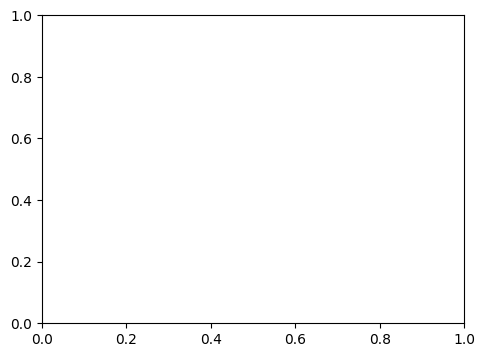

In [19]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], c='red')
plt.plot(history.history['val_accuracy'], c='green')
plt.title('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])


plt.subplot(122)
plt.plot(history.history['loss'], c='red')
plt.plot(history.history['val_loss'], c='green')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Loss')
plt.show()

## Extracting Feature map for a sample image

TensorShape([1, 250, 665])

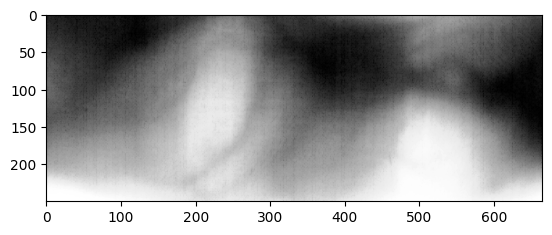

In [41]:
filter_layer = my_model.layers[-5]

# test_img = clahe_imgs[0]
test_img11 = equalized_imgs[0]
test_img12 = equalized_imgs[1]
test_img21 = equalized_imgs[6]
test_img22 = equalized_imgs[7]

plt.imshow(test_img[0], cmap='gray')

test_img11 = tf.expand_dims(test_img11, axis=0)
test_img12 = tf.expand_dims(test_img12, axis=0)
test_img21 = tf.expand_dims(test_img21, axis=0)
test_img22 = tf.expand_dims(test_img22, axis=0)

test_img11.shape

In [42]:
def get_feature_maps(model, filter_layer, img):
    # Create a model that will return these outputs, given the model input
    fm_model = Model(inputs=model.inputs, outputs=filter_layer.output)

    # Use the model to predict the features
    feature_maps = fm_model.predict(img)
    
    return feature_maps[0][0]

feature_maps11 = get_feature_maps(my_model, filter_layer, test_img11)
feature_maps12 = get_feature_maps(my_model, filter_layer, test_img12)
feature_maps21 = get_feature_maps(my_model, filter_layer, test_img21)
feature_maps22 = get_feature_maps(my_model, filter_layer, test_img22)

1/1 [==============================] - 0s 464ms/step


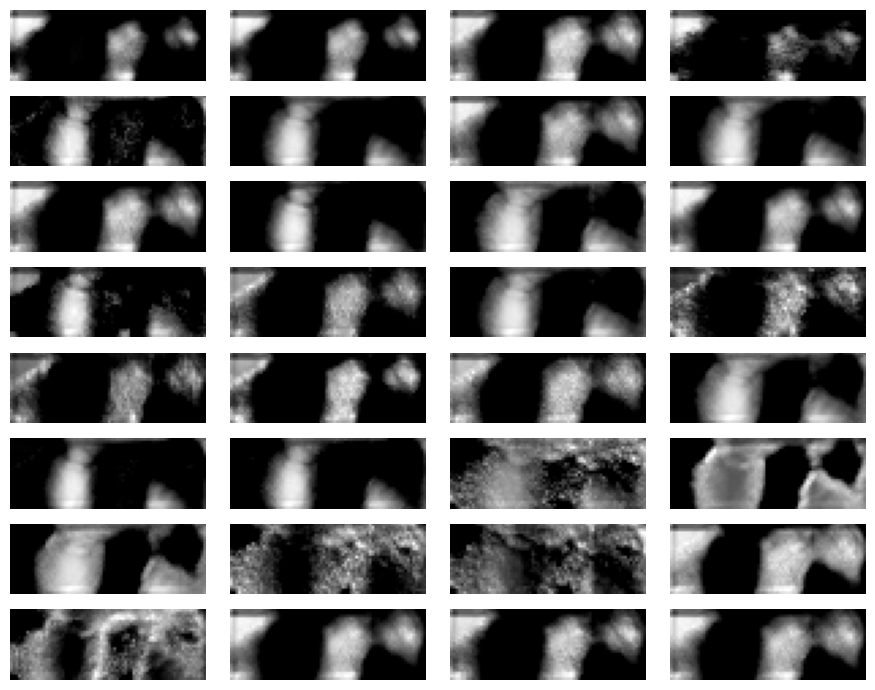

In [43]:
def viz_features(feature_maps, save_fig = False):
    
    plt.figure(figsize=(9,7))
    for i in range(feature_maps.shape[-1]):
        plt.subplot(8, 4, i+1)

        plt.axis('off')
        plt.tight_layout()

        plt.imshow(feature_maps[:, :, i], cmap='gray')
    plt.savefig('feature_maps')
    plt.show()

viz_features(feature_maps11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


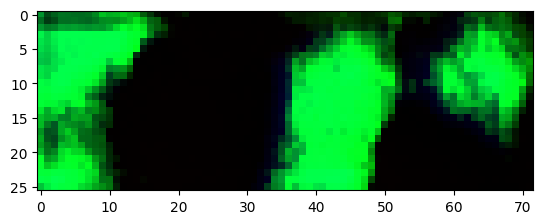

In [44]:
# Merging 3 images to form 3 channel image

three_dim_img11 = np.dstack((feature_maps11[:, :, 22], feature_maps11[:, :, 16], feature_maps11[:, :, 29]))
three_dim_img11.shape

plt.imshow((three_dim_img11))

In [45]:
feature_maps11.shape

(26, 72, 32)

In [46]:
feature_maps11[:, :, 0].max(), feature_maps11[:, :, 0].min() 

(2.0346293, 0.0)

(255, 0)

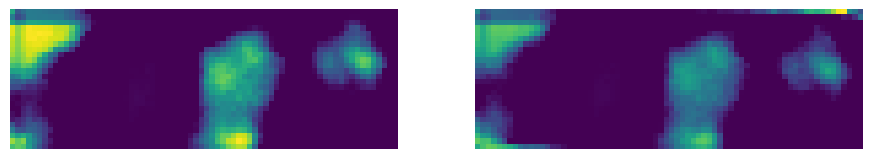

In [50]:
def min_max_norm(img):
    
    test_fm, mx, mn = img[:, :, 0], img[:, :, 0].max(), img[:, :, 0].min() 
    new_fm = np.uint8((test_fm - mn) / (mx - mn) * 255)
    
    return new_fm

new_fm11 = min_max_norm(feature_maps11)
new_fm12 = min_max_norm(feature_maps12)
new_fm21 = min_max_norm(feature_maps21)
new_fm22 = min_max_norm(feature_maps22)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.imshow(feature_maps11[:, :, 0])
plt.axis('off')

plt.subplot(122)
plt.imshow(new_fm12)
plt.axis('off')

new_fm.max(), new_fm.min()

## Testing with 4 sample to generate template

(-0.5, 664.5, 249.5, -0.5)

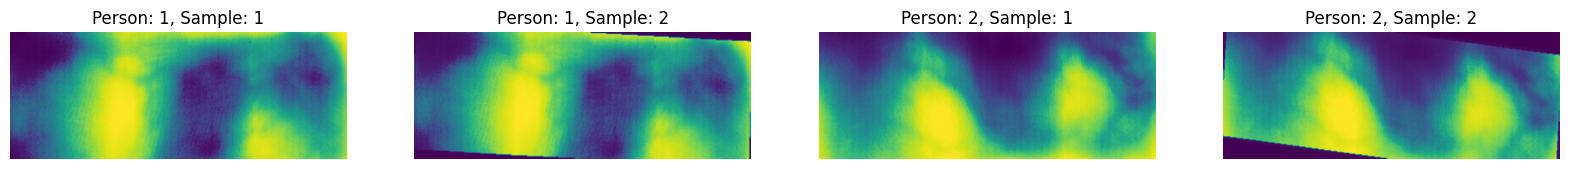

In [54]:
# tmp11 = clahe_imgs[0].copy()
# tmp12 = clahe_imgs[1].copy()
# tmp21 = clahe_imgs[6].copy()
# tmp22 = clahe_imgs[7].copy()

tmp11 = equalized_imgs[0].copy()
tmp12 = equalized_imgs[1].copy()
tmp21 = equalized_imgs[6].copy()
tmp22 = equalized_imgs[7].copy()

# tmp11 = new_fm11.copy()
# tmp12 = new_fm12.copy()
# tmp21 = new_fm21.copy()
# tmp22 = new_fm22.copy()


tmp11 = tf.expand_dims(tmp11, axis = 0)
tmp12 = tf.expand_dims(tmp12, axis = 0)
tmp21 = tf.expand_dims(tmp21, axis = 0)
tmp22 = tf.expand_dims(tmp22, axis = 0)

tmp11.shape, tmp12.shape, tmp21.shape, tmp22.shape

plt.figure(figsize=(20,8))

plt.subplot(141)
plt.imshow(tmp11[0])
plt.title('Person: 1, Sample: 1')
plt.axis('off')

plt.subplot(142)
plt.imshow(tmp12[0])
plt.title('Person: 1, Sample: 2')
plt.axis('off')

plt.subplot(143)
plt.imshow(tmp21[0])
plt.title('Person: 2, Sample: 1')
plt.axis('off')

plt.subplot(144)
plt.imshow(tmp22[0])
plt.title('Person: 2, Sample: 2')
plt.axis('off')

1/1 [==============================] - 0s 384ms/step


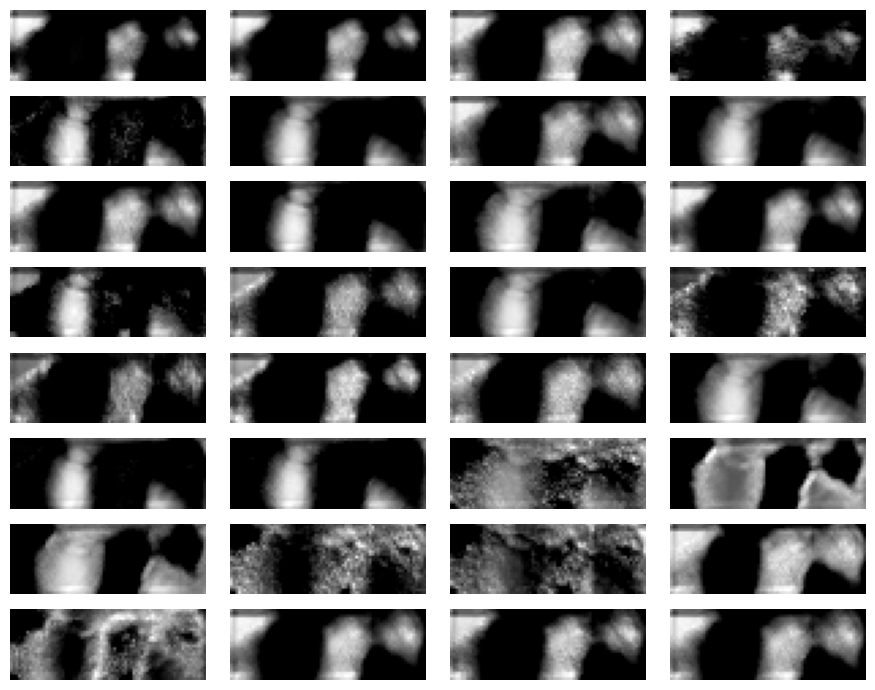

In [55]:
fm11 = get_feature_maps(my_model, filter_layer, tmp11)
viz_features(fm11)

1/1 [==============================] - 0s 365ms/step


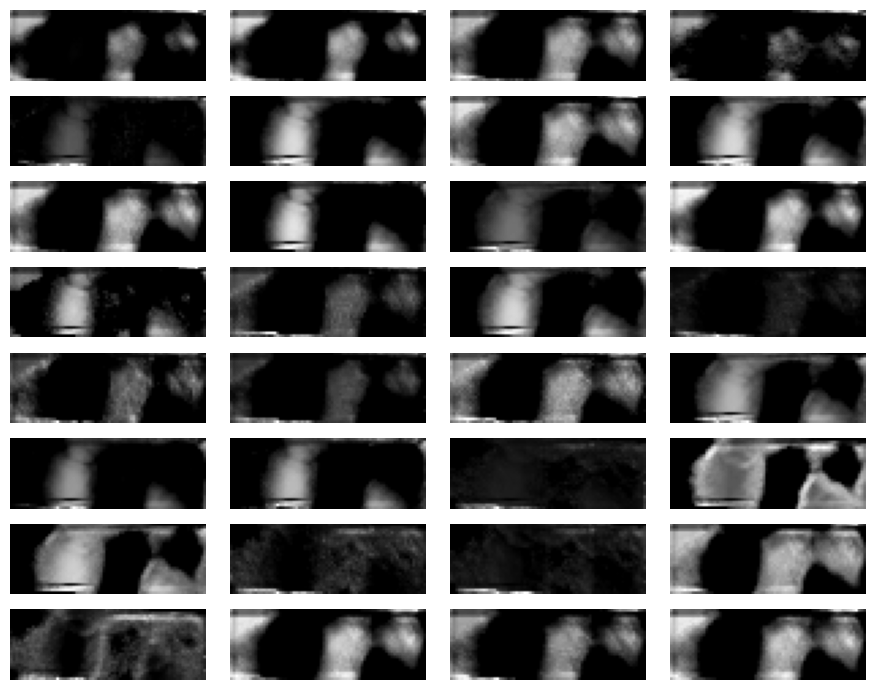

In [56]:
fm12 = get_feature_maps(my_model, filter_layer, tmp12)
viz_features(fm12)

1/1 [==============================] - 0s 352ms/step


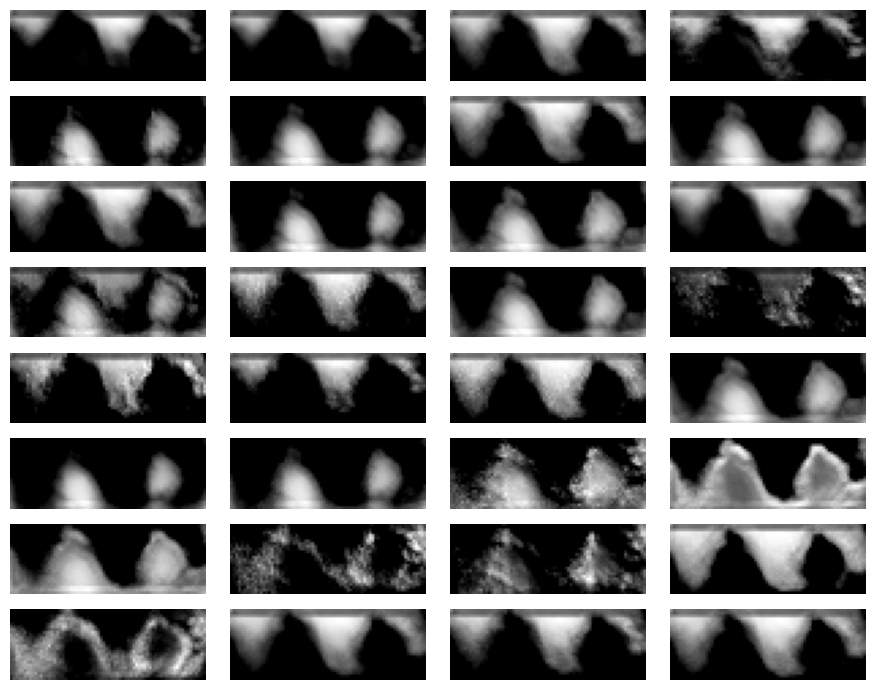

In [57]:
fm21 = get_feature_maps(my_model, filter_layer, tmp21)
viz_features(fm21)

1/1 [==============================] - 0s 352ms/step


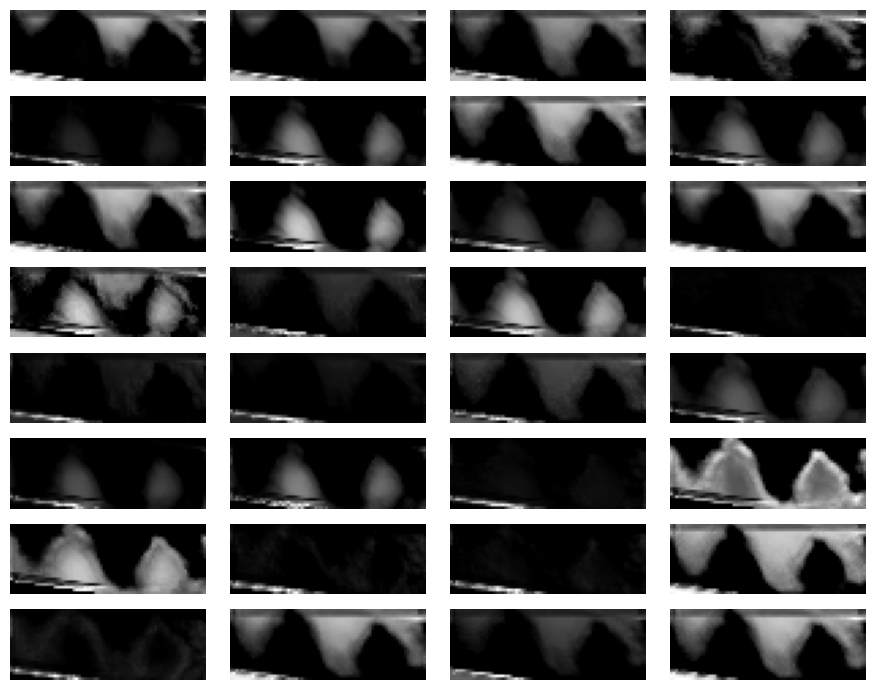

In [58]:
fm22 = get_feature_maps(my_model, filter_layer, tmp22)
viz_features(fm22)

In [60]:
# Generate template for all images in dataset
temp_images = []
fms = [fm11[::,0], fm12[::,0], fm21[::,0], fm22[::,0]] # Take first feature map from each samples

iterations = 10
for img in fms:
    batch_temp = inf_cube_with_itr_with_exchange(img, iterations)
    temp_images.append(np.array(batch_temp))

temp_images = np.array(temp_images)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 1744830464 bytes in function 'cv::OutOfMemoryError'


In [ ]:
for ind, imgs in enumerate(images.take(3)):
    plt.figure(figsize=(14,7))

    plt.subplot(131)
    plt.imshow(np.uint8(imgs[0][ind]))
    plt.title(f'S{ind+1}: sample {ind+1} image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(clahe_imgs[ind])
    plt.title(f'S{ind+1}: sample {ind+1} CLAHE image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(temp_images[ind])
    plt.title(f'S{ind+1}: sample {ind+1} template')
    plt.axis('off')

    plt.show()
    plt.tight_layout()

## Template Generation

In [ ]:
# Generate template for all images in dataset
temp_images = []
iterations = 10
for img in clahe_imgs:
    batch_temp = inf_cube_with_itr(img, iterations)
    temp_images.append(np.array(batch_temp))

temp_images = np.array(temp_images)

In [ ]:
temp_images.shape

In [ ]:
for ind, imgs in enumerate(images.take(3)):
    plt.figure(figsize=(14,7))

    plt.subplot(131)
    plt.imshow(np.uint8(imgs[0][ind]))
    plt.title(f'S{ind+1}: sample {ind+1} image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(clahe_imgs[ind])
    plt.title(f'S{ind+1}: sample {ind+1} CLAHE image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(temp_images[ind])
    plt.title(f'S{ind+1}: sample {ind+1} template')
    plt.axis('off')

    plt.show()
    plt.tight_layout()

In [ ]:
# img = clahe_imgs[0][0]
# ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
# ret, thresh2 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
# ret, thresh3 = cv2.threshold(img, 120, 255, cv2.THRESH_TRUNC)
# ret, thresh4 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO)
# ret, thresh5 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO_INV)
  
# # the window showing output images
# # with the corresponding thresholding 
# # techniques applied to the input images
# cv2.imshow('Binary Threshold', thresh1)
# cv2.imshow('Binary Threshold Inverted', thresh2)
# cv2.imshow('Truncated Threshold', thresh3)
# cv2.imshow('Set to 0', thresh4)
# cv2.imshow('Set to 0 Inverted', thresh5)

In [ ]:
# # Function to calculate cosine similarity between two vectors
# def cosine_similarity(vector_a, vector_b):
#     dot_product = np.dot(vector_a, vector_b)
#     norm_a = np.linalg.norm(vector_a)
#     norm_b = np.linalg.norm(vector_b)
#     similarity = dot_product / (norm_a * norm_b)
#     return similarity

In [ ]:
# sample_templates = temp_images[:40]
# similarity_scores_genuine = []
# similarity_scores_impostor = []

# for i, imgs in enumerate(sample_templates):
#     for j, image_a_sp in enumerate(imgs):
#         histogram_a_sp = cv2.calcHist([image_a_sp], channels=[0,1,2], mask=None, histSize=[256,256,256], ranges=[0, 256, 0, 256, 0, 256])
#         histogram_a_sp = histogram_a_sp.flatten() / np.sum(histogram_a_sp)  # Normalize the histogram
        
#         # Other templates of same person
#         for k, image_b_sp in enumerate(imgs):
#             if j == k:
#                 continue
#             histogram_b_sp = cv2.calcHist([image_b_sp], channels=[0,1,2], mask=None, histSize=[256,256,256], ranges=[0, 256, 0, 256, 0, 256])
#             histogram_b_sp = histogram_b_sp.flatten() / np.sum(histogram_b_sp)  # Normalize the histogram
            
#             similarity_score = cosine_similarity(histogram_a_sp, histogram_b_sp)
#             similarity_scores_genuine.append(similarity_score)
    
#     # Other templates of different persons
#     for k, other_temps in enumerate(sample_templates):
#         if k == i:
#             continue

#         for image_b_dp in other_temps:
#             histogram_b_dp = cv2.calcHist([image_b_dp], channels=[0,1,2], mask=None, histSize=[256,256,256], ranges=[0, 256, 0, 256, 0, 256])
#             histogram_b_dp = histogram_b_dp.flatten() / np.sum(histogram_b_dp)  # Normalize the histogram
            
#             similarity_score = cosine_similarity(histogram_a_sp, histogram_b_dp)
#             similarity_scores_impostor.append(similarity_score)

In [ ]:
# # Calculate KDE for similarity scores
# kde_genuine = gaussian_kde(similarity_scores_genuine)
# kde_impostor = gaussian_kde(similarity_scores_impostor)

# # Generate range for similarity scores
# x = np.linspace(0, 1, 100)

# # Calculate frequency using KDE
# frequency_genuine = kde_genuine(x)
# frequency_impostor = kde_impostor(x)

# # Plot PDFs
# plt.figure(figsize=(10, 6))
# plt.plot(x, frequency_genuine, color='b', label='Genuine')
# plt.plot(x, frequency_impostor, color='r', label='Impostor')
# plt.title('Probability Density Function (PDF) of Genuine and Impostor Similarity Scores')
# plt.xlabel('Similarity')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

# Compare templates of different samples

In [ ]:
# dset can take 'template' and 'clahe_img' for getting sample images
dset = 'template'
# dset = 'clahe_img'

if dset == 'template':
    # Get template for applying SIFT
    for ind, imgs in enumerate(clahe_imgs):
            tmp11 = temp_images[0].copy()
            tmp12 = temp_images[1].copy()
            tmp21 = temp_images[6].copy()
            tmp22 = temp_images[7].copy()

if dset == 'clahe_img':
    # Get CLAHE enhanced images for SIFT generation
    tmp11 = clahe_imgs[0].copy()
    tmp12 = clahe_imgs[1].copy()
    tmp21 = clahe_imgs[6].copy()
    tmp22 = clahe_imgs[7].copy()

In [ ]:
plt.figure(figsize=(14,7))

gray11 = cv2.cvtColor(tmp11, cv2.COLOR_BGR2GRAY)
gray12 = cv2.cvtColor(tmp12, cv2.COLOR_BGR2GRAY)
gray21 = cv2.cvtColor(tmp21, cv2.COLOR_BGR2GRAY)
gray22 = cv2.cvtColor(tmp22, cv2.COLOR_BGR2GRAY)

plt.subplot(221)
plt.imshow(tmp11)
plt.title('template Person 1, Sample 1')
plt.axis('off')

plt.subplot(222)
plt.imshow(tmp12)
plt.title('template Person 1, Sample 2')
plt.axis('off')

plt.subplot(223)
plt.imshow(tmp21)
plt.title('template Person 2, Sample 1')
plt.axis('off')

plt.subplot(224)
plt.imshow(tmp22)
plt.title('template Person 2, Sample 2')
plt.axis('off')

plt.tight_layout()

Fractal Analysis

In [ ]:
def calculate_fractal_dimension(temp_image):

    # Apply edge detection (you can use other methods for feature extraction)
    edges = cv2.Canny(img, 100, 200)

    # Calculate the fractal dimension using the box-counting method
    width, height = edges.shape
    box_size = min(width, height) // 2
    counts = []

    while box_size >= 2:
        count = 0
        for x in range(0, width, box_size):
            for y in range(0, height, box_size):
                sub_image = edges[x:x + box_size, y:y + box_size]
                if np.sum(sub_image) > 0:
                    count += 1
        counts.append(count)
        box_size //= 2

    # Fit a linear regression line to the data points (log-log plot)
    x = np.log(1 / np.array(counts[:-1]))
    y = np.log(counts[1:])
    slope, intercept = np.polyfit(x, y, 1)

    return -slope  # Fractal dimension is the negative of the slope

In [ ]:
fd1 = calculate_fractal_dimension(tmp11)
fd2 = calculate_fractal_dimension(tmp12)

print(f"Fractal Dimension of Image 1: {fd1}")
print(f"Fractal Dimension of Image 2: {fd2}")

In [ ]:
from skimage import io, color, metrics

# Load the two images
image1 = tmp11.copy()
image2 = tmp12.copy()

# Convert images to grayscale for SSIM calculation
image1_gray = color.rgb2gray(image1)
image2_gray = color.rgb2gray(image2)

# Calculate SSIM
ssim = metrics.structural_similarity(image1_gray, image2_gray)

# Calculate the Mean Squared Error (MSE) between the images
mse = np.mean((image1-image2) ** 2)

# You can define a threshold for SSIM and MSE to determine similarity
ssim_threshold = 0.9
mse_threshold = 1000

if ssim > ssim_threshold and mse < mse_threshold:
    print("The images are similar.")
else:
    print("The images are different.")


## Correlation cv2.filter2D

In [ ]:
corr1111 = cv2.filter2D(tmp11, ddepth=-1, kernel=tmp11)
corr1112 = cv2.filter2D(tmp11, ddepth=-1, kernel=tmp12)

corr1121 = cv2.filter2D(tmp11, ddepth=-1, kernel=tmp21)
corr1122 = cv2.filter2D(tmp11, ddepth=-1, kernel=tmp22)

corr1221 = cv2.filter2D(tmp12, ddepth=-1, kernel=tmp21)
corr1222 = cv2.filter2D(tmp12, ddepth=-1, kernel=tmp22)

corr2111 = cv2.filter2D(tmp21, ddepth=-1, kernel=tmp11)
corr2112 = cv2.filter2D(tmp21, ddepth=-1, kernel=tmp12)

corr2121 = cv2.filter2D(tmp21, ddepth=-1, kernel=tmp21)
corr2122 = cv2.filter2D(tmp21, ddepth=-1, kernel=tmp22)

In [ ]:
plt.imshow(corr1111)

## Correlation Coefficient

In [ ]:
np.corrcoef(tmp11.flatten(), tmp11.flatten())

In [ ]:
np.corrcoef(tmp11.flatten(), tmp12.flatten())

In [ ]:
np.corrcoef(tmp11.flatten(), tmp21.flatten())

In [ ]:
np.corrcoef(tmp11.flatten(), tmp22.flatten())

In [ ]:
np.corrcoef(tmp12.flatten(), tmp21.flatten())

In [ ]:
np.corrcoef(tmp21.flatten(), tmp22.flatten())

## SIFT Implementation

In [ ]:
plt.figure(figsize=(14,7))

# create SIFT feature extractor
sift = cv2.SIFT_create()

# detect features from the image
# keypoints11, descriptors = sift.detectAndCompute(tmp11, None)
keypoints11, descriptors11 = sift.detectAndCompute(tmp11, None)
keypoints12, descriptors12 = sift.detectAndCompute(tmp12, None)
keypoints21, descriptors21 = sift.detectAndCompute(tmp21, None)
keypoints22, descriptors22 = sift.detectAndCompute(tmp22, None)

# draw the detected key points
sift_image11 = cv2.drawKeypoints(gray11, keypoints11, tmp11)
sift_image12 = cv2.drawKeypoints(gray12, keypoints12, tmp12)
sift_image21 = cv2.drawKeypoints(gray21, keypoints21, tmp21)
sift_image22 = cv2.drawKeypoints(gray22, keypoints22, tmp22)

# show the image
plt.subplot(221)
plt.imshow(sift_image11)
plt.axis('off')

plt.subplot(222)
plt.imshow(sift_image12)
plt.axis('off')

plt.subplot(223)
plt.imshow(sift_image21)
plt.axis('off')

plt.subplot(224)
plt.imshow(sift_image22)
plt.axis('off')

# # save the image
# cv2.imwrite("table-sift.jpg", sift_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L1)

# match descriptors of both images
matches11_11 = bf.knnMatch(descriptors11, descriptors11, k=2)
matches11_12 = bf.knnMatch(descriptors11, descriptors12, k=2)
matches11_21 = bf.knnMatch(descriptors11, descriptors21, k=2)
matches11_22 = bf.knnMatch(descriptors11, descriptors22, k=2)

matches12_12 = bf.knnMatch(descriptors12, descriptors12, k=2)
matches12_21 = bf.knnMatch(descriptors12, descriptors21, k=2)
matches12_22 = bf.knnMatch(descriptors12, descriptors22, k=2)

matches21_21 = bf.knnMatch(descriptors21, descriptors21, k=2)
matches21_22 = bf.knnMatch(descriptors21, descriptors22, k=2)

matches22_22 = bf.knnMatch(descriptors22, descriptors22, k=2)

In [ ]:
# Apply ratio test
good11_11 = []
good11_12 = []
good11_21 = []
good11_22 = []

good12_12 = []
good12_21 = []
good12_22 = []

good21_21 = []
good21_22 = []

good22_22 = []

for m,n in matches11_11:
    if m.distance < 0.75*n.distance:
        good11_11.append(m)

for m,n in matches11_12:
    if m.distance < 0.75*n.distance:
        good11_12.append(m)

for m,n in matches11_21:
    if m.distance < 0.75*n.distance:
        good11_21.append(m)

for m,n in matches11_22:
    if m.distance < 0.75*n.distance:
        good12_21.append(m)

for m,n in matches12_12:
    if m.distance < 0.75*n.distance:
        good12_12.append(m)

for m,n in matches12_21:
    if m.distance < 0.75*n.distance:
        good21_22.append(m)

for m,n in matches12_22:
    if m.distance < 0.75*n.distance:
        good12_22.append(m)

for m,n in matches21_21:
    if m.distance < 0.75*n.distance:
        good21_21.append(m)

for m,n in matches21_22:
    if m.distance < 0.75*n.distance:
        good21_22.append(m)

for m,n in matches22_22:
    if m.distance < 0.75*n.distance:
        good22_22.append(m)

# draw first 50 matches
matched_img11_11 = cv2.drawMatches(tmp11, keypoints11, tmp11, keypoints11, good11_11, tmp11, flags=2)
matched_img11_12 = cv2.drawMatches(tmp11, keypoints11, tmp12, keypoints12, good11_12, tmp12, flags=2)
matched_img11_21 = cv2.drawMatches(tmp11, keypoints11, tmp21, keypoints21, good11_21, tmp21, flags=2)
matched_img11_22 = cv2.drawMatches(tmp11, keypoints11, tmp22, keypoints22, good11_22, tmp22, flags=2)

matched_img12_12 = cv2.drawMatches(tmp12, keypoints12, tmp12, keypoints12, good12_12, tmp12, flags=2)
matched_img12_21 = cv2.drawMatches(tmp12, keypoints12, tmp21, keypoints21, good12_21, tmp21, flags=2)
matched_img12_22 = cv2.drawMatches(tmp12, keypoints12, tmp22, keypoints22, good12_22, tmp22, flags=2)

matched_img21_21 = cv2.drawMatches(tmp21, keypoints21, tmp21, keypoints21, good21_21, tmp21, flags=2)
matched_img21_22 = cv2.drawMatches(tmp21, keypoints21, tmp22, keypoints22, good21_22, tmp22, flags=2)

matched_img22_22 = cv2.drawMatches(tmp22, keypoints22, tmp22, keypoints22, good22_22, tmp22, flags=2)

In [ ]:
len(good11_12), len(good11_21), len(good11_22), len(good12_21), len(good12_22), len(good21_22)

In [ ]:
# What is this Matcher Object?
# The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:

# DMatch.distance-Distance between descriptors. The lower, the better it is.
# DMatch.trainIdx-Index of the descriptor in train descriptors
# DMatch.queryIdx-Index of the descriptor in query descriptors
# DMatch.imgIdx-Index of the train image.

# good11_12[0].distance, good11_12[0].trainIdx, good11_12[0].queryIdx, good11_12[0].imgIdx

In [ ]:
# show the image
plt.figure(figsize=(20,10))
plt.imshow(matched_img11_11)
plt.axis('off')
plt.title('Comparing 11 11')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img11_12)
plt.title('Comparing 11 12')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img11_21)
plt.title('Comparing 11 21')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img11_22)
plt.title('Comparing 11 22')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img12_12)
plt.title('Comparing 12 12')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img12_21)
plt.title('Comparing 12 21')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img12_22)
plt.title('Comparing 12 22')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img21_21)
plt.title('Comparing 21 21')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img21_22)
plt.title('Comparing 21 22')
plt.axis('off')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(matched_img22_22)
plt.title('Comparing 22 22')
plt.axis('off')
plt.show()